In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numba import jit

from scipy.stats import norm

from scipy.stats import qmc

np.warnings.filterwarnings("ignore")

plt.style.use('Solarize_Light2')

In [2]:
seed_gen = np.random.default_rng(seed=42)

In [3]:
# Sampling methods
# @jit(nopython=True)
# def complex_matrix(x_range, y_range, density):
#     """
#     Args:
#         x_range     range of the real component
#         y_range     range of the imaginary component
#         density     Number of samples
#     Returns:
#         Complex Matrix     
#     """
#     re = np.linspace(x_range[0],x_range[1], int((x_range[1] - y_range[0]) * density))
#     im = np.linspace(y_range[0],y_range[1], int((y_range[1] - y_range[0]) * density))

#     return re[np.newaxis, :] + im[:, np.newaxis] * 1j

@jit(nopython=True)
def random_sampling(x_range, y_range, density, seed=42):
    """
    Uses np.random.random to generate PRNGs: https://numpy.org/doc/stable/reference/random/generated/numpy.random.random.html
    Returns randomly sampled points within a given range
    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
        density     Number of samples
    Returns: 
        random_c  Array with sampled complex numbers
    """
    X = (x_range[1]-x_range[0])*np.random.random(density) + x_range[0]
    Y = (y_range[1]-y_range[0])*np.random.random(density) + y_range[0]
    random_complex = X + Y * 1j
    
    return random_complex

# @jit(nopython=True)
def latin_and_ortho(x_range, y_range, density, ortho=False, seed=42):
    """
    Latin hypercube sampling in 2 dimensions, with optional possibility for orthogonal sampling.
    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
        density     Number of samples
    Returns:
        random_c    Array with sampled complex numbers
    """
    # space = Space([x_range, y_range])

    # latin = Lhs(lhs_type='classic', criterion=None)
    # samples = np.asarray(latin.generate(space.dimensions, density))

    if not ortho:
        sampler = qmc.LatinHypercube(d=2, seed=seed)
    
    else:
        sampler = qmc.LatinHypercube(d=2, strength=2, seed=seed)

    sample = sampler.random(n=density)

    # Rearranging the bounds for LHC scaling
    l_bounds = np.asarray([x_range[0], y_range[0]])
    u_bounds = np.asarray([x_range[1], y_range[1]])

    sample = qmc.scale(sample, l_bounds, u_bounds)
    samples = np.asarray(sample)

    re = samples[:, 0]
    im = samples[:, 1]

    random_c = re + im * 1j

    return random_c

In [4]:
# Rejection Sampling
@jit(nopython=True)
def rejection_sampling(x_range, y_range, C, max_iterations=150):
    """
    Estimates the area of the mandelbrot set by keeping bounded values
    and discarding diverging values.

    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
    Returns:
        Area        Area estimation
    """

    Z = np.zeros_like(C)
    T = np.zeros(C.shape)

    for i in range(max_iterations):
        M = Z.real ** 2 + Z.imag ** 2 <= 2

        Z[M] = Z[M] ** 2 + C[M]

        T[M] = i + 1

        # sub_total = np.count_nonzero(T)
        # sub_area = (sub_total/len(C)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

    total = np.count_nonzero(T == max_iterations)
    area = (total/len(C)) * (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

    return area, M

In [5]:
# TEsting the sampling methods

x_range = [-2., 0.5]
y_range = [-1.5, 1.5]

sample_size =  10201 # 6241 #  #   529 
max_iterations = 100

# Sampling points
# c = complex_matrix(x_range, y_range, density=sample_size)

random_sample = random_sampling(x_range, y_range, density=sample_size)
latin_sample = latin_and_ortho(x_range, y_range, density=sample_size)
ortho_sample = latin_and_ortho(x_range, y_range, density=sample_size, ortho=True)

# Area estimation
# counted_area = rejection_sampling(x_range, y_range, c)

random_area, M_random = rejection_sampling(x_range, y_range, random_sample)
latin_area, M_latin = rejection_sampling(x_range, y_range, latin_sample)
ortho_area, M_ortho = rejection_sampling(x_range, y_range, ortho_sample)

Ms = [M_random, M_latin, M_ortho]

# print(counted_area[0])
print(random_area)
print(latin_area)
print(ortho_area)

1.56087638466817
1.5263209489265759
1.5314675031859621


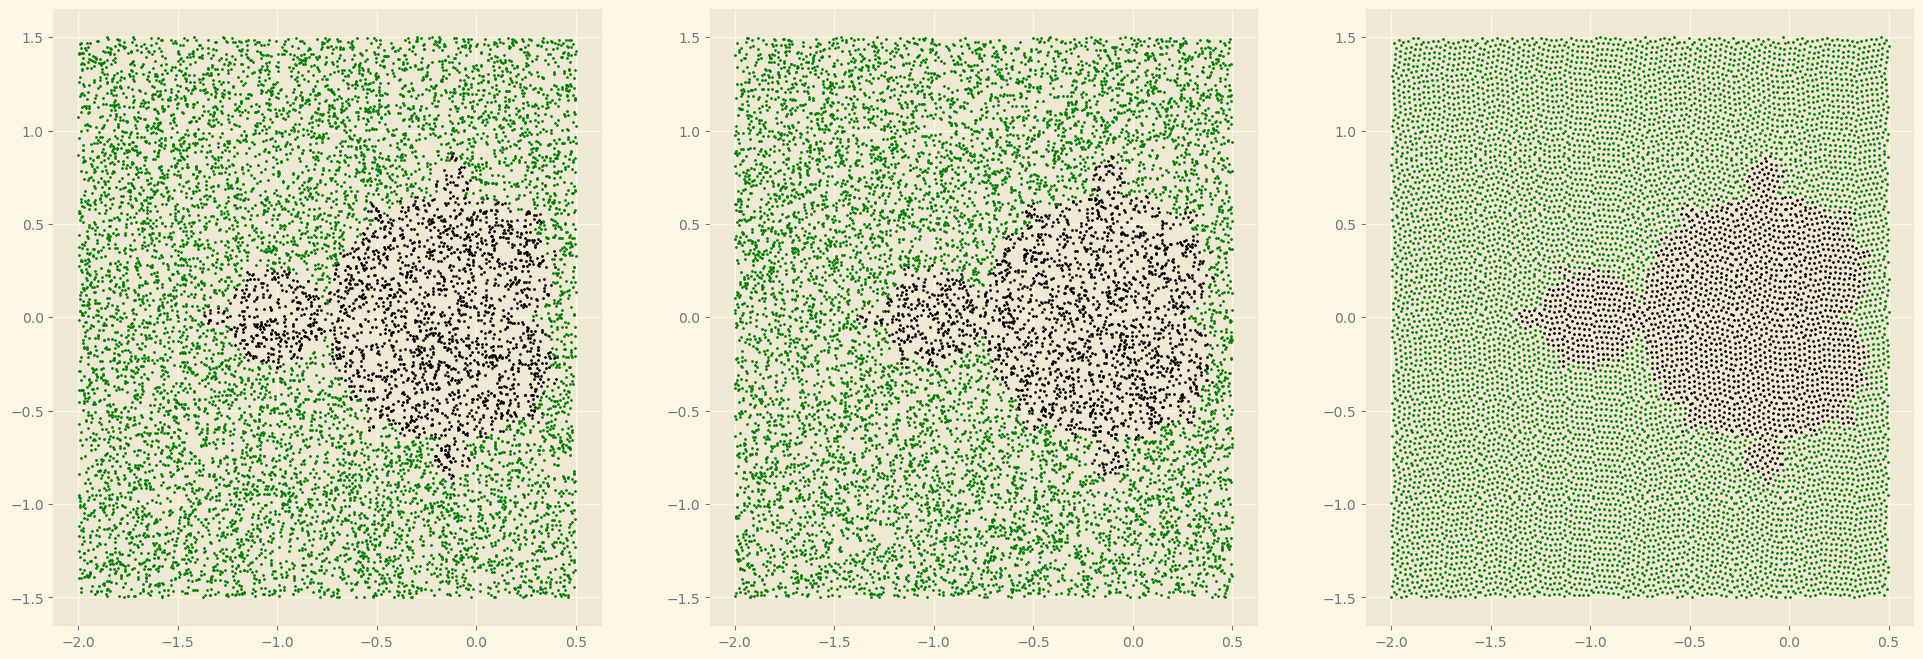

In [6]:
# PLotting

fig, ax = plt.subplots(1,3, figsize=(24,8))
for i, type in enumerate([random_sample, latin_sample, ortho_sample]):
    ax[i].plot([z.real for z in type[Ms[i]]], [z.imag for z in type[Ms[i]]], 'ko', markersize =1)
    ax[i].plot([z.real for z in type[~Ms[i]]], [z.imag for z in type[~Ms[i]]], 'go', markersize =1)


# Convergence Rate (Improvement)

s is the number of samples used for the area estimation, while i is the iteration count.

In [7]:
@jit(nopython=True)
def iteration_conv(x_range, y_range, C, max_iter_count=150):
    """
    Estimates the area of the mandelbrot using a range of iteration values

    Args:
        x_range     range of the real component
        y_range     range of the imaginary component
    Returns:
        Area        Area estimation
    """

    Areas = np.zeros(max_iter_count)

    for i in range(1, max_iter_count):
        area, Ms = rejection_sampling(x_range, y_range, C, max_iterations=i)
        Areas[i] = area
    
    return Areas

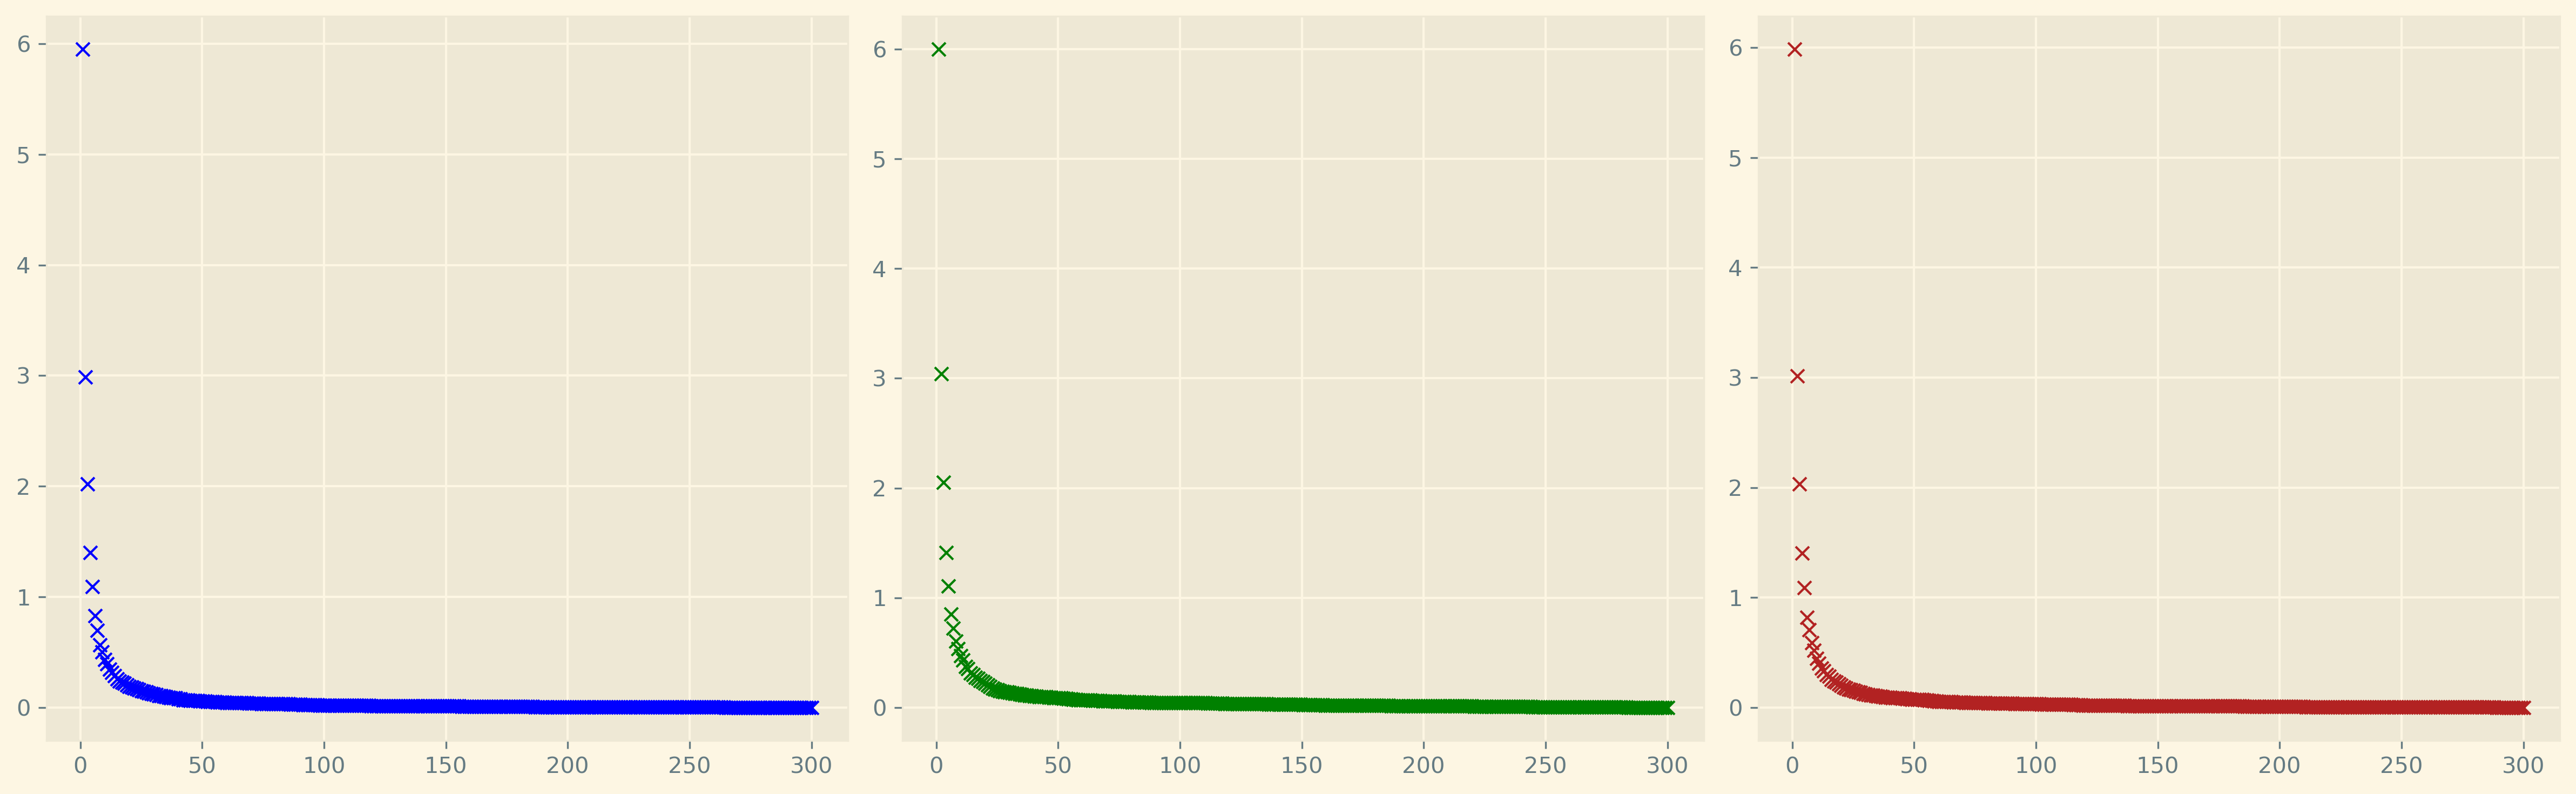

In [8]:
# Testing the functions
N_i = 300
x_i = np.linspace(1,N_i,N_i-1)

rand_areas = iteration_conv(x_range, y_range, random_sample, max_iter_count=N_i)
lhs_areas = iteration_conv(x_range, y_range, latin_sample, max_iter_count=N_i)
ortho_areas = iteration_conv(x_range, y_range, ortho_sample, max_iter_count=N_i)

converged_area = [areas[-1] for areas in [rand_areas, lhs_areas, ortho_areas]] # [rand_areas[-1], lhs_areas[-1], ortho_areas[-1]]
colors = ['blue', 'green', 'firebrick']


plt.figure(figsize=(16,5), dpi=300)
for i, type in enumerate([rand_areas, lhs_areas, ortho_areas]):
    relative_errors = [np.abs(area - converged_area[i]) for area in type]
    plt.subplot(131+i)
    plt.plot(x_i, relative_errors[1:], 'x', color=colors[i])
    
plt.tight_layout()
plt.show()

# Varying Sample Size
Next, we generate various densities for our respective sampling methods. We must adhere to using the squares of prime numbers as a density value, since the orthogonal sampling method has this as a constraint.

In [9]:
def primesfrom2to(n):
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = np.ones(n//3 + (n%6==2), dtype=bool)
    for i in range(1,int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[       k*k//3     ::2*k] = False
            sieve[k*(k-2*(i&1)+4)//3::2*k] = False
    return np.r_[2,3,((3*np.nonzero(sieve)[0][1:]+1)|1)]


In [10]:
N_s = 120
num_repeats = 8

primes = primesfrom2to(N_s)
density_values = primes**2

no_densities = len(primes)

rep_Areas = np.zeros((no_densities, 3)) # Areas for all sampling types at various densities, with repeated sampling for statistics

for n in range(num_repeats):
    seed = n
    Areas = np.zeros((no_densities, 3)) # Areas for all 3 sampling types at various densities

    for s, density in enumerate(density_values):
        random_sample = random_sampling(x_range, y_range, density, seed=seed)
        latin_sample= latin_and_ortho(x_range, y_range, density, seed=seed)
        ortho_sample = latin_and_ortho(x_range, y_range, density, ortho=True, seed=seed)
        for t, sample in enumerate([random_sample, latin_sample, ortho_sample]):
            Areas[s, t], M = rejection_sampling(x_range, y_range, sample, max_iterations=100)
    if not rep_Areas.any():
        rep_Areas = Areas
    else:
        rep_Areas = np.vstack((rep_Areas, Areas))

### Mean
mean_Areas = np.zeros((no_densities,3))

indeces = np.full(num_repeats, no_densities) # array of length num_repeats, filled with the number of densities
indeces = indeces * range(len(indeces)) # multiply by K*density count, with K = 0,1,2...num_repeats

for i in indeces:
    for j in range(no_densities):
        mean_Areas[j] = mean_Areas[j] +  rep_Areas[j+i]

mean_Areas = mean_Areas * 1/num_repeats

### Standard Deviation
std_Areas = np.zeros((no_densities, 3))

split_Arr = np.array_split(rep_Areas, num_repeats)

for t in range(3):
    density_stds = np.zeros(no_densities) # An array holding each density
    for i in range(no_densities):
        std_list = np.zeros(num_repeats)# create list for each density which contains all area measurements across the repeats
        for rep_num, sub_arr in enumerate(split_Arr):
            area = sub_arr[i, t]
            std_list[rep_num] = area
        std = np.std(std_list)
        density_stds[i] = std

    std_Areas[:, t] = density_stds

30


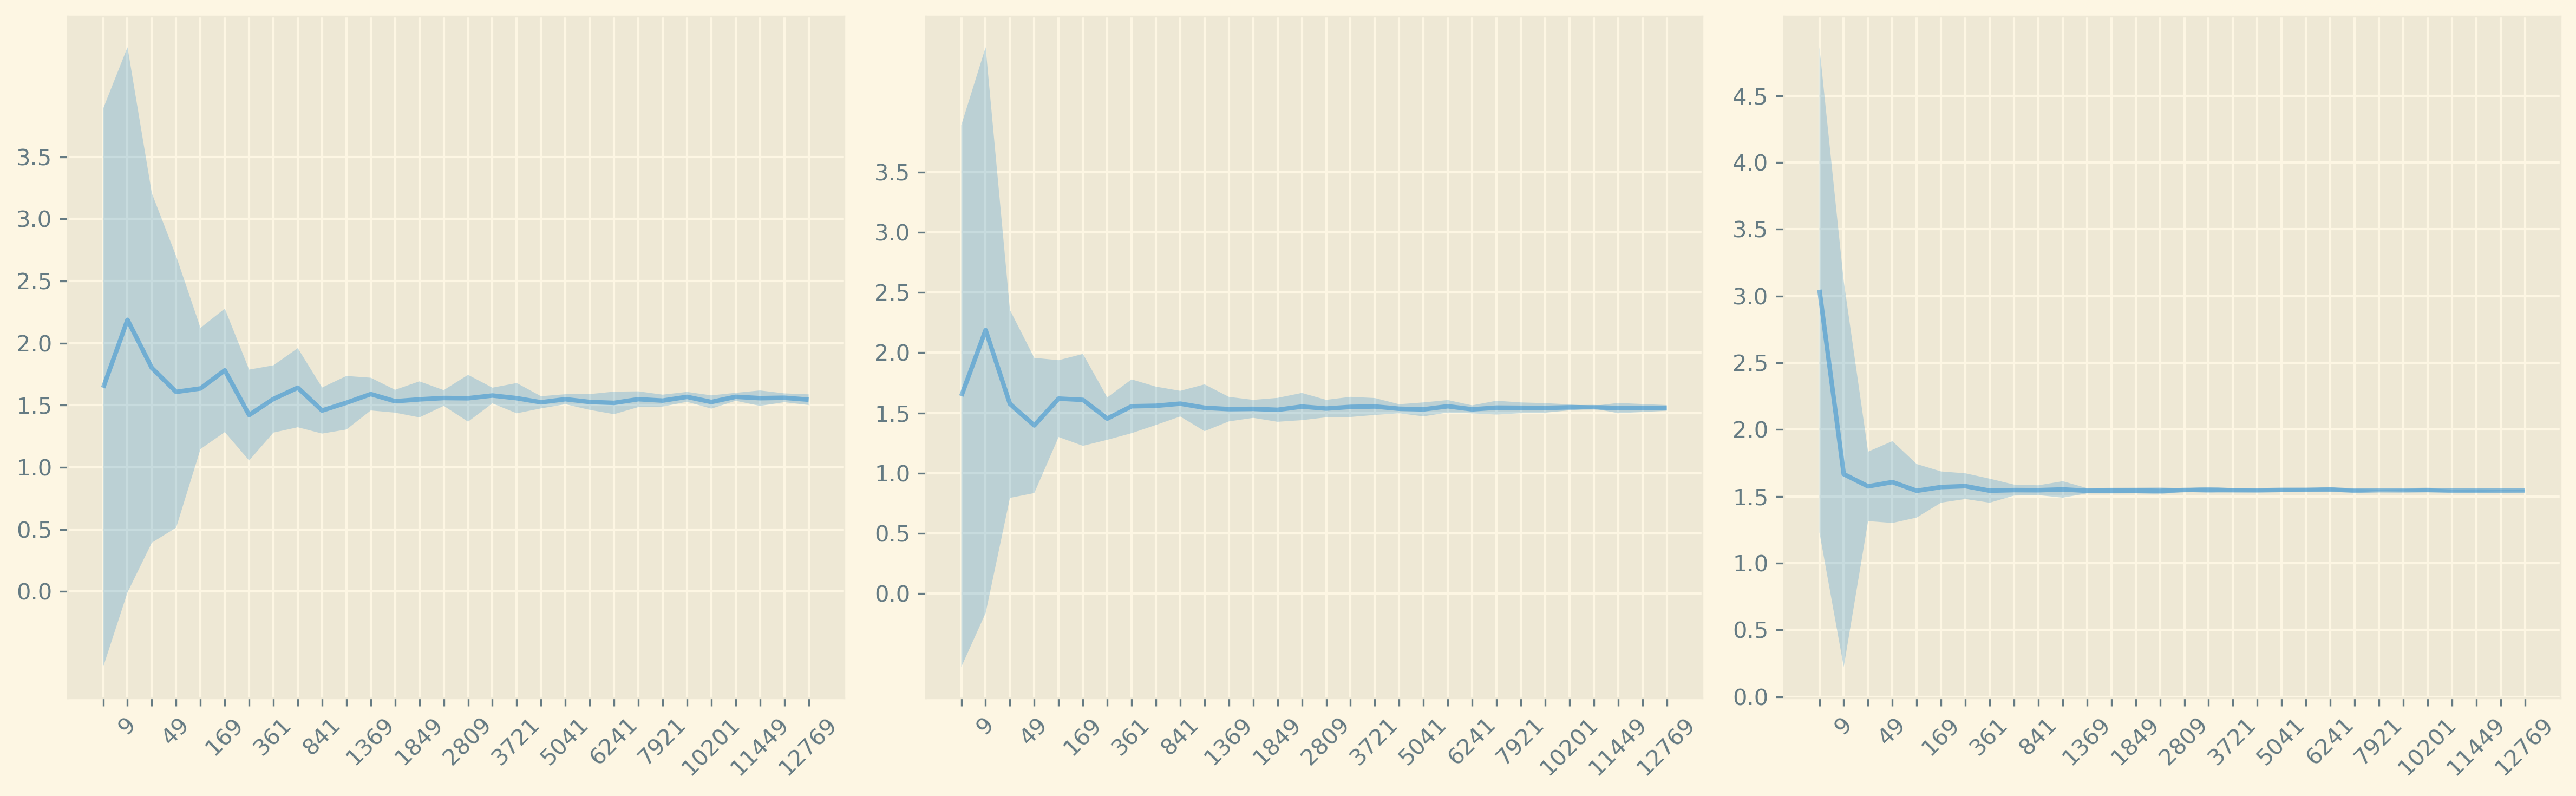

In [11]:
# x = range(len(mean_Areas[:,0])) 
x = [str(val) for val in density_values]
print(len(x))

plt.figure(figsize=(16,5), dpi=300)
for i in range(3):
    plt.subplot(131+i)
    upper = mean_Areas[:, i] + 2*std_Areas[:, i]
    lower = mean_Areas[:, i] - 2*std_Areas[:, i]
    plt.plot(x, mean_Areas[:, i], alpha=0.5)
    plt.fill_between(x, lower, upper,alpha=0.25)

    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation = 45)

    start, end = [int(lim) for lim in ax.get_ylim()] # alternatively, plt.ylim
    ax.yaxis.set_ticks(np.arange(start, end, 0.5)) # alternatively, plt.yticks(np.arange...)

    # Setting every second x_tick invisible
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

plt.tight_layout()
plt.show()

# Confidence Intervals

In [12]:
intervals = np.linspace(0.5, 0.999, 50)
crit_val = np.array([norm.ppf(interval + (1 - interval)/2) for interval in intervals])
